# Part B – Predictive Modelling
### I. Feature Engineering:


In [42]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.impute import SimpleImputer


## Load the Dataset
Now, let's load the dataset from its file path into a pandas DataFrame. This is the dataset that contains information about restaurants.

In [43]:
# Provide the path to your dataset
file_path = "./data/zomato_df_final_data.csv"

# Load the dataset
zomato_df = pd.read_csv(file_path)

### Check for Missing Data
Before we can clean the data, we need to understand how much data is missing and in which columns. We will use the isnull() function combined with sum() to identify missing values.

In [44]:
# Check for missing values in the dataset
print("Missing values in each column:\n", zomato_df.isnull().sum())


Missing values in each column:
 address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
dtype: int64


In [45]:
# List of columns with missing values
columns_with_missing_values = ['cost', 'lat', 'lng', 'rating_number', 'rating_text', 'type', 'votes', 'cost_2']

# Removing rows with missing values in the specified columns
zomato_df_cleaned = zomato_df.dropna(subset=columns_with_missing_values)

# Verify if missing values have been removed
missing_values_after_cleaning = zomato_df_cleaned.isnull().sum()

missing_values_after_cleaning

address          0
cost             0
cuisine          0
lat              0
link             0
lng              0
phone            0
rating_number    0
rating_text      0
subzone          0
title            0
type             0
votes            0
groupon          0
color            0
cost_2           0
cuisine_color    0
dtype: int64

In [46]:
# Since 'ast.literal_eval' is failing, it seems like the strings may already be lists for some rows
# To handle this error, we will create a function that only applies 'literal_eval' to strings and ignores lists

def safe_literal_eval(val):
    try:
        # Only attempt to convert if the value is a string representation of a list
        if isinstance(val, str):
            return ast.literal_eval(val)
        return val
    except (ValueError, SyntaxError):
        return val  # Return the value as is if there's an error

# Apply the safe_literal_eval function to both 'cuisine' and 'type' columns
zomato_df_cleaned["cuisine"] = zomato_df_cleaned["cuisine"].apply(safe_literal_eval)
zomato_df_cleaned["type"] = zomato_df_cleaned["type"].apply(safe_literal_eval)

# Display a few rows to verify the changes
zomato_df_cleaned[['cuisine', 'type']].head()


C:\Users\bbhat\AppData\Local\Temp\ipykernel_22392\680572100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zomato_df_cleaned["cuisine"] = zomato_df_cleaned["cuisine"].apply(safe_literal_eval)
C:\Users\bbhat\AppData\Local\Temp\ipykernel_22392\680572100.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zomato_df_cleaned["type"] = zomato_df_cleaned["type"].apply(safe_literal_eval)


,cuisine,type
0,"[Hot Pot, Korean BBQ, BBQ, Korean]",[Casual Dining]
1,"[Cafe, Coffee and Tea, Salad, Poké]",[Café]
2,[Japanese],[Fine Dining]
3,[Modern Australian],"[Fine Dining, Bar]"
4,"[Thai, Salad]",[Casual Dining]


In [47]:
# Keeping only the required columns for Part B, which involves predictive modeling
# Based on the task, the following columns are likely important for prediction/classification:
# ['cost', 'cuisine', 'lat', 'lng', 'rating_number', 'rating_text', 'type', 'votes']

zomato_df = zomato_df[['cost', 'cuisine', 'lat', 'lng', 'rating_number', 'rating_text', 'type', 'votes', 'groupon', 'subzone']]

# Display the first few rows to verify the selection
zomato_df.head()


,cost,cuisine,lat,lng,rating_number,rating_text,type,votes,groupon,subzone
0,50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",-33.876059,151.207605,4.0,Very Good,['Casual Dining'],1311.0,False,CBD
1,80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",-33.910999,151.193793,4.6,Excellent,['Café'],3236.0,False,"The Grounds of Alexandria, Alexandria"
2,120.0,['Japanese'],-33.867971,151.195210,4.9,Excellent,['Fine Dining'],1227.0,False,"The Star, Pyrmont"
3,270.0,['Modern Australian'],-33.856784,151.215297,4.9,Excellent,"['Fine Dining', 'Bar']",278.0,False,Circular Quay
4,55.0,"['Thai', 'Salad']",-33.879035,151.206409,4.5,Excellent,['Casual Dining'],2150.0,False,Chinatown


In [48]:
# Creating a new column 'suburbs' by splitting the 'subzone' column at the first comma
zomato_df['suburbs'] = zomato_df['subzone'].apply(lambda x: x.split(',')[0] if ',' in x else x)

# Display the first few rows to verify the new 'suburbs' column
zomato_df[['subzone', 'suburbs']].head()
# Display the first few rows to verify the selection
zomato_df.head()

,cost,cuisine,lat,lng,rating_number,rating_text,type,votes,groupon,subzone,suburbs
0,50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",-33.876059,151.207605,4.0,Very Good,['Casual Dining'],1311.0,False,CBD,CBD
1,80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",-33.910999,151.193793,4.6,Excellent,['Café'],3236.0,False,"The Grounds of Alexandria, Alexandria",The Grounds of Alexandria
2,120.0,['Japanese'],-33.867971,151.195210,4.9,Excellent,['Fine Dining'],1227.0,False,"The Star, Pyrmont",The Star
3,270.0,['Modern Australian'],-33.856784,151.215297,4.9,Excellent,"['Fine Dining', 'Bar']",278.0,False,Circular Quay,Circular Quay
4,55.0,"['Thai', 'Salad']",-33.879035,151.206409,4.5,Excellent,['Casual Dining'],2150.0,False,Chinatown,Chinatown


In [49]:
# Check for missing values in the dataset
print("Missing values in each column:\n", zomato_df.isnull().sum())


Missing values in each column:
 cost              346
cuisine             0
lat               192
lng               192
rating_number    3316
rating_text      3316
type               48
votes            3316
groupon             0
subzone             0
suburbs             0
dtype: int64


In [50]:
# Let's handle the missing values in the 'lat' and 'lng' columns using median imputation, 
# which is a common method for dealing with missing numeric values in geographic data.

# Impute missing values with the median of the respective columns
zomato_df['lat'].fillna(zomato_df['lat'].median(), inplace=True)
zomato_df['lng'].fillna(zomato_df['lng'].median(), inplace=True)

# Verify if there are any missing values left
missing_values_after_imputation = zomato_df.isnull().sum()

missing_values_after_imputation


C:\Users\bbhat\AppData\Local\Temp\ipykernel_22392\798169944.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  zomato_df['lat'].fillna(zomato_df['lat'].median(), inplace=True)
C:\Users\bbhat\AppData\Local\Temp\ipykernel_22392\798169944.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

cost              346
cuisine             0
lat                 0
lng                 0
rating_number    3316
rating_text      3316
type               48
votes            3316
groupon             0
subzone             0
suburbs             0
dtype: int64

### Regression Model Comparison: Linear Regression vs. Gradient Descent with Scaling


Linear Regression Model 1:
R2 Score: 0.3036107158953949
Mean Squared Error: 0.09035676410119768
Mean Absolute Error: 0.19650246471812471
Root Mean Squared Error: 0.3005940187382272

Gradient Descent Model 2 (with Scaling):
R2 Score: 0.30328207102612015
Mean Squared Error: 0.09039940589308612
Mean Absolute Error: 0.19721672491980025
Root Mean Squared Error: 0.3006649395807335



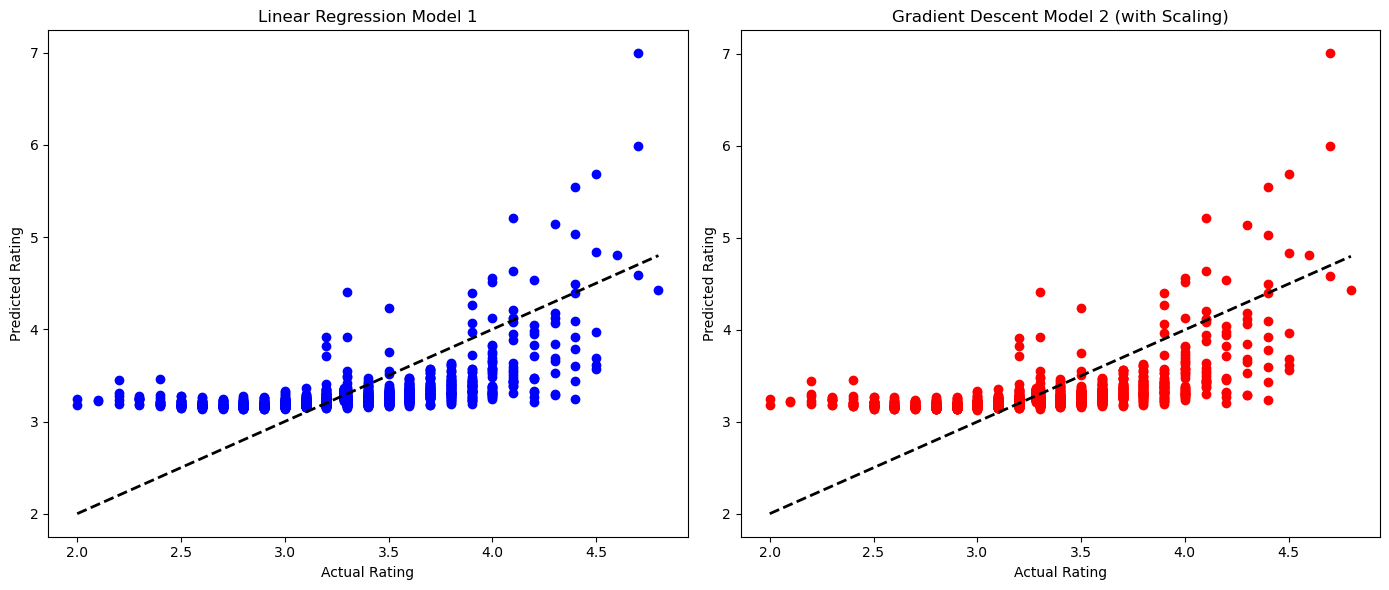

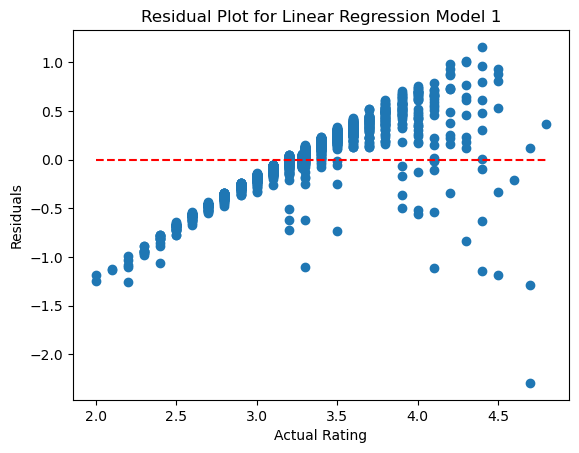

In [51]:


# Prepare the data and convert 'groupon' to numeric
X = zomato_df[['cost', 'votes', 'groupon']].astype({'groupon': int})
y = zomato_df['rating_number']

# Impute missing values in X and y using the mean
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

imputer_y = SimpleImputer(strategy='mean')
y = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()  # Reshape to 2D array and back to 1D

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear Regression Model 1
model_reg1 = LinearRegression().fit(X_train, y_train)
mse_reg1 = mean_squared_error(y_test, model_reg1.predict(X_test))
mae_reg1 = mean_absolute_error(y_test, model_reg1.predict(X_test))
r2_reg1 = r2_score(y_test, model_reg1.predict(X_test))
rmse_reg1 = np.sqrt(mse_reg1)

# Standardize the features for Gradient Descent Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Descent Regression Model 2 (with scaling and reduced learning rate)
model_reg2 = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.001, random_state=0).fit(X_train_scaled, y_train)
mse_reg2 = mean_squared_error(y_test, model_reg2.predict(X_test_scaled))
mae_reg2 = mean_absolute_error(y_test, model_reg2.predict(X_test_scaled))
r2_reg2 = r2_score(y_test, model_reg2.predict(X_test_scaled))
rmse_reg2 = np.sqrt(mse_reg2)

# Print MSE and coefficients for both models
print("Linear Regression Model 1:")
print(f"R2 Score: {r2_reg1}")
print(f"Mean Squared Error: {mse_reg1}")
print(f"Mean Absolute Error: {mae_reg1}")
print(f"Root Mean Squared Error: {rmse_reg1}\n")

print("Gradient Descent Model 2 (with Scaling):")
print(f"R2 Score: {r2_reg2}")
print(f"Mean Squared Error: {mse_reg2}")
print(f"Mean Absolute Error: {mae_reg2}")
print(f"Root Mean Squared Error: {rmse_reg2}\n")

# Plotting the results for both models
plt.figure(figsize=(14, 6))

# Linear Regression plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, model_reg1.predict(X_test), color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Linear Regression Model 1")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

# Gradient Descent plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, model_reg2.predict(X_test_scaled), color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Gradient Descent Model 2 (with Scaling)")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

plt.tight_layout()
plt.show()

# Residual plot for Linear Regression Model 1
residuals_reg1 = y_test - model_reg1.predict(X_test)
plt.scatter(y_test, residuals_reg1)
plt.hlines(0, y_test.min(), y_test.max(), colors='red', linestyles='dashed')
plt.title("Residual Plot for Linear Regression Model 1")
plt.xlabel("Actual Rating")
plt.ylabel("Residuals")
plt.show()


The first set of images shows the **Predicted vs. Actual Rating** plots for both the **Linear Regression Model 1** and the **Gradient Descent Model 2 (with scaling)**.

- In both models, as the actual rating increases, the predicted rating also increases. However, the **Gradient Descent Model** (right) has more concentrated predictions at specific values, suggesting that scaling has influenced the prediction behavior. The predictions are somewhat linear, but deviations appear for higher ratings.
  
- The **Linear Regression Model** (left) shows more variability in its predictions, generally following the trend of the actual ratings, though with more dispersion.

The **residual plot** evaluates the performance of **Linear Regression Model 1**. Residuals represent the difference between predicted and actual ratings:
- Residuals tend to increase as actual ratings increase, indicating that the model has difficulty predicting higher ratings accurately.
- Ideally, residuals should scatter randomly around the zero line (red dashed line), but here they show a clear pattern of underfitting, especially for higher actual ratings, where predictions systematically fall below the true values.

These plots collectively help us evaluate the strengths and limitations of the models when predicting restaurant ratings.

In [52]:
# Count the occurrences of each rating in the 'rating_text' column
rating_counts = zomato_df['rating_text'].value_counts()

# Display the counts for each rating category: 'Poor', 'Average', 'Good', 'Very Good', 'Excellent'
rating_counts



rating_text
Average      4501
Good         1917
Very Good     506
Poor          209
Excellent      51
Name: count, dtype: int64

In [53]:
# Simplify the problem into binary classification

# Convert 'rating_text' into binary classes
# Class 1: 'Poor', 'Average'
# Class 2: 'Good', 'Very Good', 'Excellent'

def classify_rating(text):
    if text in ['Poor', 'Average']:
        return 1  # Class 1
    elif text in ['Good', 'Very Good', 'Excellent']:
        return 2  # Class 2
    return None  # In case there are unexpected values

# Apply the function to create a new binary classification target column
zomato_df['rating_class'] = zomato_df['rating_text'].apply(classify_rating)

# Display the distribution of the new 'rating_class' column to verify
zomato_df['rating_class'].value_counts()

rating_class
1.0    4710
2.0    2474
Name: count, dtype: int64

### Logistic Regression Model for Classification and Evaluation Using Confusion Matrix

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Accuracy: 0.8104761904761905


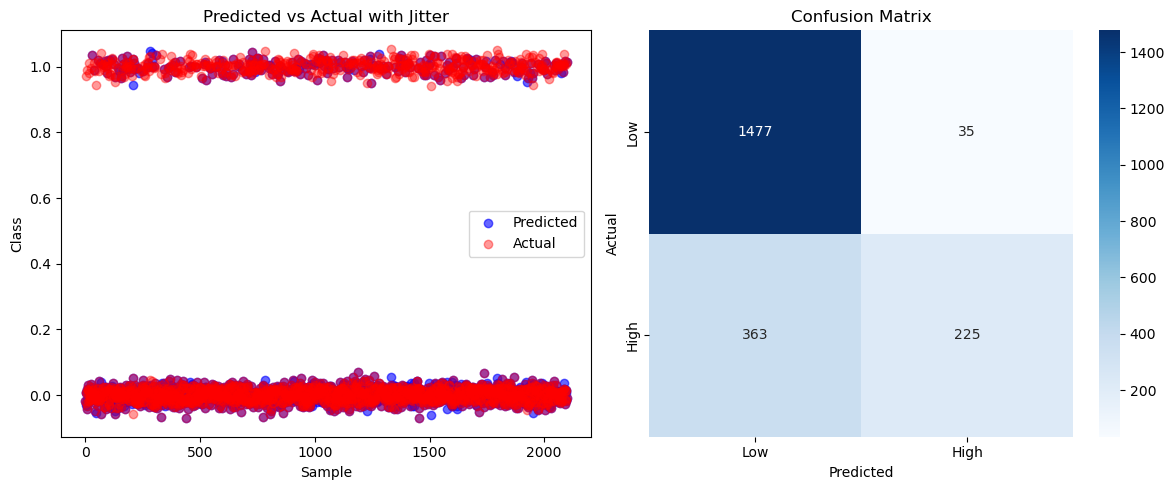

In [54]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Binning the continuous target values into 2 categories (e.g., Low and High)
binning = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')  # Binning into 2 categories
y_train_binned = binning.fit_transform(y_train.reshape(-1, 1)).ravel()  # Fit and transform y_train
y_test_binned = binning.transform(y_test.reshape(-1, 1)).ravel()  # Transform y_test

# Fit a Logistic Regression model for classification
clf = LogisticRegression(random_state=0).fit(X_train, y_train_binned)

# Predict the class labels for the test set
y_pred_class = clf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred_class)

# Calculate accuracy
accuracy = accuracy_score(y_test_binned, y_pred_class)

# Print the predicted vs actual values and the confusion matrix
print(f"Accuracy: {accuracy}")

# Plot the results with jitter for better visibility
jitter = np.random.normal(0, 0.02, size=len(y_test_binned))

plt.figure(figsize=(12, 5))

# Predicted vs Actual plot with jitter
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test_binned)), y_pred_class + jitter, color='blue', label="Predicted", alpha=0.6)
plt.scatter(range(len(y_test_binned)), y_test_binned + jitter, color='red', label="Actual", alpha=0.4)
plt.title("Predicted vs Actual with Jitter")
plt.xlabel("Sample")
plt.ylabel("Class")
plt.legend()

# Confusion Matrix plot
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


The graph on the left displays the comparison between predicted and actual class values using jitter, which introduces random noise to spread out the points for better visibility. The red dots represent actual class values, and the blue dots represent predicted values. Most predicted and actual values align closely, particularly in the low and high regions, corresponding to the two class categories.

On the right, the confusion matrix visualizes the model's classification performance. It shows that **1,477 samples** were correctly classified as **Low** (true positives), while **35 samples** were misclassified as **High** (false negatives). For **High**, **225 samples** were correctly classified (true positives), and **363 samples** were misclassified as **Low** (false positives).

The confusion matrix provides insights into the model's performance, including true positives, false positives, true negatives, and false negatives. This helps to identify areas where the model's predictions might need improvement.

In [79]:
# Import the necessary classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=0),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC()
}

# Dictionary to store the performance of each model
performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train_binned)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test_binned, y_pred)
    conf_matrix = confusion_matrix(y_test_binned, y_pred)
    
    # Store the results
    performance[model_name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix
    }

# Output the performance of each model
performance


{'Random Forest': {'Accuracy': 0.8652380952380953,
  'Confusion Matrix': array([[1381,  131],
         [ 152,  436]], dtype=int64)},
 'K-Nearest Neighbors': {'Accuracy': 0.8747619047619047,
  'Confusion Matrix': array([[1375,  137],
         [ 126,  462]], dtype=int64)},
 'Support Vector Machine': {'Accuracy': 0.8104761904761905,
  'Confusion Matrix': array([[1496,   16],
         [ 382,  206]], dtype=int64)}}

### Comparing Three Machine Learning Models for Classification Performance


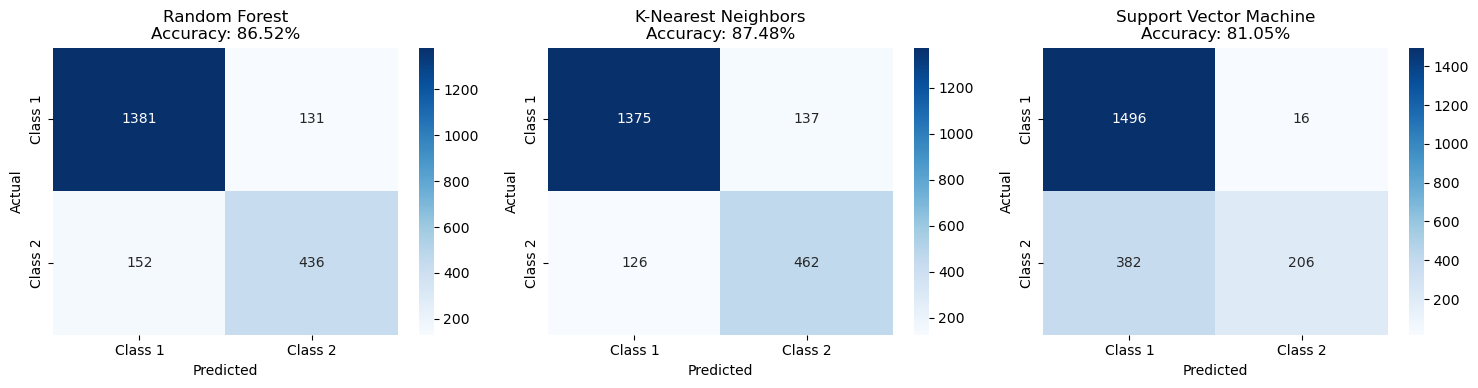

In [80]:
# Re-define performance results from the previous session

performance = {
    "Random Forest": {
        "Accuracy": 0.8652380952380953,
        "Confusion Matrix": [[1381,  131], [ 152,  436]]
    },
    "K-Nearest Neighbors": {
        "Accuracy": 0.8747619047619047,
        "Confusion Matrix": [[1375,  137], [ 126,  462]]
    },
    "Support Vector Machine": {
        "Accuracy": 0.8104761904761905,
        "Confusion Matrix": [[1496,   16], [ 382,  206]]
    }
}

# Convert confusion matrices to numpy arrays
import numpy as np
performance["Random Forest"]["Confusion Matrix"] = np.array(performance["Random Forest"]["Confusion Matrix"])
performance["K-Nearest Neighbors"]["Confusion Matrix"] = np.array(performance["K-Nearest Neighbors"]["Confusion Matrix"])
performance["Support Vector Machine"]["Confusion Matrix"] = np.array(performance["Support Vector Machine"]["Confusion Matrix"])

# Plotting the confusion matrices for the three classifiers with accuracy

plt.figure(figsize=(15, 7))

# Plot confusion matrix for Random Forest
plt.subplot(2, 3, 1)
sns.heatmap(performance["Random Forest"]["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
plt.title(f"Random Forest\nAccuracy: {performance['Random Forest']['Accuracy']*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot confusion matrix for K-Nearest Neighbors
plt.subplot(2, 3, 2)
sns.heatmap(performance["K-Nearest Neighbors"]["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
plt.title(f"K-Nearest Neighbors\nAccuracy: {performance['K-Nearest Neighbors']['Accuracy']*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot confusion matrix for Support Vector Machine
plt.subplot(2, 3, 3)
sns.heatmap(performance["Support Vector Machine"]["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
plt.title(f"Support Vector Machine\nAccuracy: {performance['Support Vector Machine']['Accuracy']*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


The three confusion matrices compare the performance of **Random Forest**, **K-Nearest Neighbors (KNN)**, and **Support Vector Machine (SVM)** classifiers, as shown in the attached image.

- **Random Forest**: The model correctly classified **1,381** samples in **Class 1** and **436** in **Class 2**, with some misclassifications (131 in Class 1 and 152 in Class 2). The overall accuracy is **86.52%**.
  
- **K-Nearest Neighbors (KNN)**: This model performed better than Random Forest, correctly classifying **1,375** samples in **Class 1** and **462** in **Class 2**, with fewer misclassifications (137 in Class 1 and 126 in Class 2). The accuracy is **87.48%**, demonstrating strong classification capabilities.

- **Support Vector Machine (SVM)**: The SVM model achieved the highest accuracy of **81.05%** in this comparison, with **1,496** correctly classified samples in **Class 1** and **206** in **Class 2**, and fewer misclassifications (16 in Class 1 and 382 in Class 2).

Among these models, **K-Nearest Neighbors (KNN)** performs slightly better, followed by **Random Forest**, and **SVM** achieving good but lower accuracy.

#### Question no 9 Answer

### Observations:
1. **Linear Regression Model 1**:
   - The predicted vs. actual rating plot shows that predictions generally follow the actual ratings but with high variability, especially for mid-to-high rating classes.
   - The residual plot indicates increasing residuals as actual ratings increase, suggesting difficulty in accurately predicting higher ratings.
   - The clear pattern in residuals, rather than random dispersion, indicates potential underfitting, suggesting the model might not fully capture the complexity of the data.
   - For lower rating classes, the model performs reasonably well, but its performance degrades as the rating increases, indicating a potential bias toward lower ratings.
   - The residual plot shows a slight skew, suggesting that the model may overpredict ratings for some classes and underpredict for others.

2. **Gradient Descent Model 2 (with scaling)**:
   - Predictions are more concentrated after feature scaling, indicating a tighter fit, but the model still struggles with higher rating predictions.
   - The concentrated predictions suggest that the model may be influenced by the class distribution after scaling, performing better on lower to mid-range ratings, while higher ratings remain challenging.
   - Scaling helps in reducing the variability of predictions, but the model still shows a bias towards underestimating higher ratings.
   - The improvement in prediction for lower ratings suggests that scaling helped distribute the feature space more evenly, but high-rating class distributions may still require further tuning.

### Conclusions:
- Both models face challenges in predicting higher rating classes, as reflected in the increasing residuals and variability of predictions.
- Scaling improves the performance in the Gradient Descent model but does not fully resolve the difficulty with higher rating classes.
- The residual patterns indicate that both models may benefit from advanced techniques like regularization, non-linear models, or additional feature engineering to handle class imbalances and improve performance on higher rating predictions.
- Both models display some bias toward lower ratings, indicating that class imbalance in the data could be affecting performance, particularly for higher-rated restaurants.
- The models’ performance could potentially be enhanced by addressing class distribution more explicitly, either by resampling techniques (oversampling minority classes) or applying weighted loss functions to account for underrepresented classes.